### Meta

In [30]:
# Autoreload modules without having to restart the notebook kernel.
# hi bilbo
%load_ext autoreload
%autoreload 2


# Plotting code stolen from Georg's notebook.
import matplotlib.pyplot as plt


%matplotlib inline
font = {'family': 'DejaVu Sans',
        'weight': 'bold',
        'size': 32}
plt.rc('font', **font)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Imports

In [31]:
import sys
sys.path.insert(1, "..\\")


#import markov_clustering as mcl
import networkx as nx
import pandas as pd
import seaborn as sns
sns.set_theme()
sns.set_style(style = "white")
import copy
import numpy as np
import time
import re


# Personal libraries
import lib.graph
import lib.files
import lib.centrality
import lib.map_names
#import lib.cluster
import lib.plot


In [32]:
# The first network is the largest connected component containing ICP55 with inviable proteins, has edges above 900 and no degree 0 nodes.
n0 = lib.graph.read_weighted_edgelist(lib.files.make_filepath_to_networks("icp55-cc-900-inv.txt"))

##Load in Julian O's df of key measures calculated on icp55 connected component, edge cutoff 900, keeping inviable proteins
network = lib.graph.read_weighted_edgelist(lib.files.make_filepath_to_networks('icp55-cc-900-inv.txt'))
master_df = pd.read_csv(lib.files.make_path_to_dataframes('icp55-cc-900-inv.mcl-2.5.nodes.dataframe.csv'), index_col=0, header=0)

In [ ]:
n0.edges()

## Validating bridging centrality

I want to know if bridging centrality does what we want it to - identify nodes that "bridge" clusters.

Methods:

Successively remove highest bridging centrality nodes in order, and see how it affects:

- Number of connected components
- Clustering coefficient (average)
- Mean shortest path between nodes
- Mean shortest path between clusters

In [37]:
#Load in Julian v's computed bridging centrality
df_bridge_sort = pd.read_csv(lib.files.path_to_tables("icp55-cc-900-inv-globalbridgingcentr.csv"), index_col = 0, header = 0)
df_bridge_sort["global_bridge_cent"] = df_bridge_sort["0"]
df_bridge_sort["protein"] = list(df_bridge_sort.index)\

#sort
df_bridge_sort = df_bridge_sort.sort_values(by = ["global_bridge_cent"],
              ascending = False)
print(df_bridge_sort.head())

                     0  global_bridge_cent       protein
4932.YGR149W  0.017724            0.017724  4932.YGR149W
4932.YHR181W  0.008014            0.008014  4932.YHR181W
4932.YJL225C  0.006480            0.006480  4932.YJL225C
4932.YJR150C  0.005430            0.005430  4932.YJR150C
4932.YBR056W  0.003020            0.003020  4932.YBR056W


#### Successive removal of highest bridging centrality nodes

This analysis mimics what is performed on Hwang et al. 2006

In [38]:
###NOTE: THIS CODE WILL TAKE SEVERAL HOURS (computation of clustering coefficient is costly). YOU CAN JUST LOAD THE COMPUTED DATA IN THE CHUNK BELOW

#Make data frame to store sequential removal stats
removal_stats_df = pd.DataFrame({"protein_removed": df_bridge_sort["protein"],
                                "bridging_centrality_removed": df_bridge_sort["global_bridge_cent"],
                                "num_nodes_removed": range(len(df_bridge_sort.index) +1)[1:]})

#Sequential remove
removed_network = copy.deepcopy(network)
num_CC = []
num_singletons = []
avg_clust_coeff = []
start = time.time()
for i in range(len(removal_stats_df.index)):
#for i in range(2):
    #removed_network = network.subgraph(list(removal_stats_df.iloc[(i + 1):, removal_stats_df.columns.get_loc("protein_removed")]))
    removed_network.remove_node(removal_stats_df.iloc[i, removal_stats_df.columns.get_loc("protein_removed")])
    
    #Number of connected components
    num_CC.append(nx.number_connected_components(removed_network))
    
    #Number of singletons
    num_singletons.append(sum(np.array(list(degree for (node, degree) in removed_network.degree())) == 0))
    
    #Avg. clustering coefficient
    avg_clust_coeff.append(nx.average_clustering(removed_network))
    
end = time.time()
print(end - start)    
    
removal_stats_df["num_CC"] = num_CC
removal_stats_df["avg_clust_coeff"] = avg_clust_coeff
removal_stats_df["num_singletons"] = num_singletons



removal_stats_df.to_csv("..\\data/tables/icp55-cc-900-inv-seq_remove_bridging.csv")

ZeroDivisionError: division by zero

Text(0, 0.5, 'Avg. clustering coefficient')

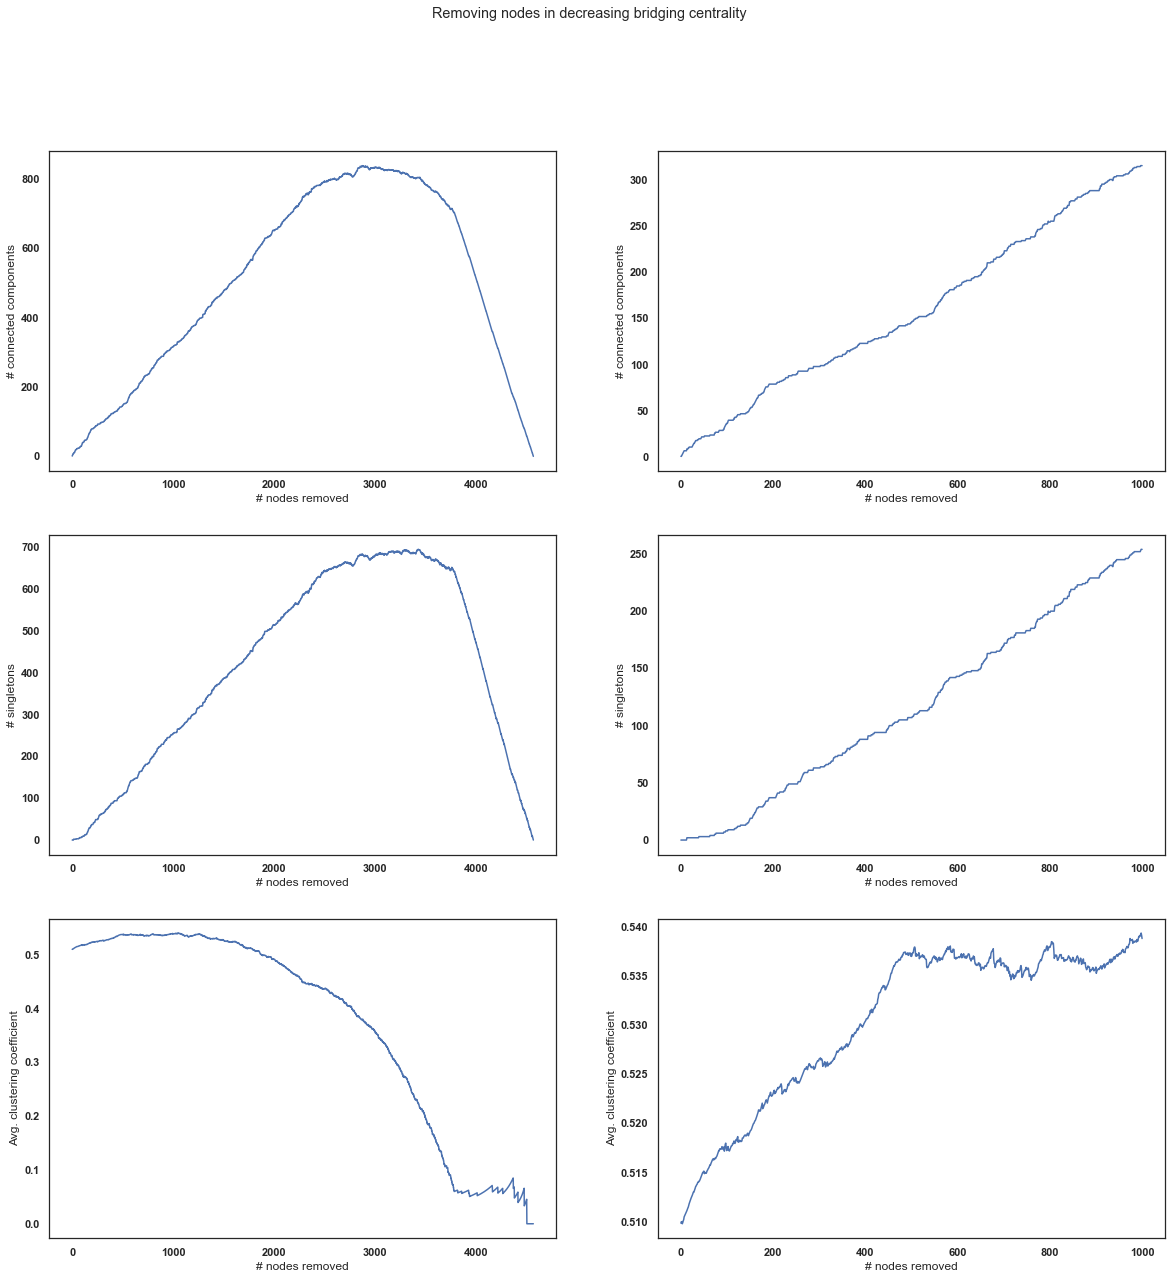

In [99]:
#Load in data if needed
#removal_stats_df = pd.read_csv("..\\data/tables/icp55-cc-900-inv-seq_remove_bridging.csv")

#Plot
fig, axes = plt.subplots(3, 2, figsize = (20, 20))
fig.suptitle("Removing nodes in decreasing bridging centrality")

sns.lineplot(data = removal_stats_df,
         x = "num_nodes_removed",
                   y = "num_CC",
            ax = axes[0, 0])
axes[0, 0].set_xlabel("# nodes removed")
axes[0, 0].set_ylabel("# connected components")

sns.lineplot(data = removal_stats_df,
         x = "num_nodes_removed",
                   y = "num_singletons",
            ax = axes[1, 0])
axes[1, 0].set_xlabel("# nodes removed")
axes[1, 0].set_ylabel("# singletons")

sns.lineplot(data = removal_stats_df,
         x = "num_nodes_removed",
                   y = "avg_clust_coeff",
            ax = axes[2, 0])
axes[2, 0].set_xlabel("# nodes removed")
axes[2, 0].set_ylabel("Avg. clustering coefficient")

sns.lineplot(data = removal_stats_df.iloc[0:999, ],
         x = "num_nodes_removed",
                   y = "num_CC",
            ax = axes[0, 1])
axes[0, 1].set_xlabel("# nodes removed")
axes[0, 1].set_ylabel("# connected components")

sns.lineplot(data = removal_stats_df.iloc[0:999, ],
         x = "num_nodes_removed",
                   y = "num_singletons",
            ax = axes[1, 1])
axes[1, 1].set_xlabel("# nodes removed")
axes[1, 1].set_ylabel("# singletons")

sns.lineplot(data = removal_stats_df.iloc[0:999, ],
         x = "num_nodes_removed",
                   y = "avg_clust_coeff",
            ax = axes[2, 1])
axes[2, 1].set_xlabel("# nodes removed")
axes[2, 1].set_ylabel("Avg. clustering coefficient")



The right column shows only the removal of the top 1000 bridging nodes. I think this is more informative.

We see that as bridging nodes are removed, the number of connected components increases, indicating the network becomes fractured. Initially (for the first ~180 nodes) there is only minimal increase in the number of singletons, suggesting this fracturing is not characterised by disconnecting single nodes.

Clustering coefficient increases steadily over the first 1000 nodes, suggesting the network is become more clustered (as we would expect). It then decreases past the first 1000 nodes.

#### Are bridging nodes in clusters?

Ideally, bridging nodes should be positioned between clusters, not within them. I test that here.

In [102]:
###Plot bridging centrality and cluster size

#Remove the 3 very high outliers
sns.relplot(data = df_bridge_sort,
           x = "global_bridge_cent",
           y = "cluster_size")


#Plot between quantiles
##THIS IS NOT REALLY WORKING - MAYBE BECAUSE THEY ARE VERY SMALL VALUES?
num_quantiles = 4
for i in range(num_quantiles):
    
    upper_quant = df_bridge_sort["global_bridge_cent"].quantile((i + 1)/num_quantiles)
    lower_quant = df_bridge_sort["global_bridge_cent"].quantile((i)/num_quantiles)
    print(lower_quant)
    print(upper_quant)
    print(len(df_bridge_sort.loc[(df_bridge_sort["global_bridge_cent"] <= upper_quant) & (df_bridge_sort["global_bridge_cent"] > lower_quant), ].index))
    
    sns.relplot(data = df_bridge_sort.loc[(df_bridge_sort["global_bridge_cent"] <= upper_quant) & (df_bridge_sort["global_bridge_cent"] > lower_quant), ],
           x = "global_bridge_cent",
           y = "cluster_size")

ValueError: Could not interpret value `cluster_size` for parameter `y`

So there is a trend for higher bridging centrality nodes to be in smaller clusters. But it is certainly just a trend.

## Exploring clusters related to ICP55 and PIM1

### Explore network of ICP55 and PIM1 2nd shell neighbours and clusters

In [70]:
###Function: concatenate a list of proteins
def protein_concatenator(protein_list):
    
    if len(protein_list) == 0:
        return("")
    
    else:    
        for i in range(len(protein_list)):
            if i == 0:
                concatenated = str(protein_list[i])
            else:
                concatenated = str(concatenated) + ";" + str(protein_list[i])

        return(concatenated)

In [82]:
###Criteria:
#Cluster has one node path length 2 or less from icp55/pim1
#Cluster size >= 5
clusters_pl2away = list(dict.fromkeys(master_df[((master_df["icp55_shell"] <= 2) | 
                                                 (master_df["pim1_shell"] <= 2)) &
                                                (master_df["cluster_size"] >= 5)]["cluster_id"]))

###Make cluster summary df
clusters_pl2away_df = pd.DataFrame({"cluster_id": clusters_pl2away})
clusters_pl2away_df["cluster_size"] = 0
clusters_pl2away_df["3mostcentral_closeness_proteins"] = ""
clusters_pl2away_df["3mostcentral_closeness_genes"] = ""
clusters_pl2away_df["3mostcentral_closeness_descriptions"] = ""
clusters_pl2away_df["3mostcentral_eigenvector_proteins"] = ""
clusters_pl2away_df["3mostcentral_eigenvector_genes"] = ""
clusters_pl2away_df["3mostcentral_eigenvector_descriptions"] = ""
clusters_pl2away_df["icp55_pl2away_proteins"] = ""
clusters_pl2away_df["pim1_pl2away_proteins"] = ""


###Add size, and top three most central proteins (by cluster eigenvector and closeness)
for i in range(len(clusters_pl2away_df.index)):
    cluster_id = clusters_pl2away_df.iloc[i, 0]
    
    #Df of all in cluster
    cluster_df = master_df[master_df["cluster_id"]  == cluster_id]
    
    #Assign cluster size
    clusters_pl2away_df.iloc[i, clusters_pl2away_df.columns.get_loc("cluster_size")] = list(cluster_df["cluster_size"])[0]
    
    #Assign top 3 closeness nodes
    top_closeness_proteins = list(cluster_df.sort_values(by = ["cluster_closeness"],
                                                                       ascending = False).iloc[0:3, master_df.columns.get_loc("protein")])
    top_closeness_genes = lib.map_names.map_names_descriptions(names = top_closeness_proteins,
                                                                name_type = "systematic_name_nonumber",
                                                                output = "gene_name")
    top_closeness_descriptions = lib.map_names.map_names_descriptions(names = top_closeness_proteins,
                                                                name_type = "systematic_name_nonumber",
                                                                output = "description")
    clusters_pl2away_df.iloc[i, clusters_pl2away_df.columns.get_loc("3mostcentral_closeness_proteins")] = protein_concatenator(top_closeness_proteins)
    clusters_pl2away_df.iloc[i, clusters_pl2away_df.columns.get_loc("3mostcentral_closeness_genes")] = protein_concatenator(top_closeness_genes)
    clusters_pl2away_df.iloc[i, clusters_pl2away_df.columns.get_loc("3mostcentral_closeness_descriptions")] = protein_concatenator(top_closeness_descriptions)
    #Assign top 3 eigenvector nodes
    top_eigenvector_proteins = list(cluster_df.sort_values(by = ["cluster_eigenvector"],
                                                                       ascending = False).iloc[0:3, master_df.columns.get_loc("protein")])
    top_eigenvector_genes = lib.map_names.map_names_descriptions(names = top_eigenvector_proteins,
                                                                name_type = "systematic_name_nonumber",
                                                                output = "gene_name")
    top_eigenvector_descriptions = lib.map_names.map_names_descriptions(names = top_eigenvector_proteins,
                                                                name_type = "systematic_name_nonumber",
                                                                output = "description")
    clusters_pl2away_df.iloc[i, clusters_pl2away_df.columns.get_loc("3mostcentral_eigenvector_proteins")] = protein_concatenator(top_eigenvector_proteins)
    clusters_pl2away_df.iloc[i, clusters_pl2away_df.columns.get_loc("3mostcentral_eigenvector_genes")] = protein_concatenator(top_eigenvector_genes)
    clusters_pl2away_df.iloc[i, clusters_pl2away_df.columns.get_loc("3mostcentral_eigenvector_descriptions")] = protein_concatenator(top_eigenvector_descriptions)
    
    #Get the specific proteins within path length 2 of icp55 or pim1
    clusters_pl2away_df.iloc[i, clusters_pl2away_df.columns.get_loc("icp55_pl2away_proteins")] = protein_concatenator(list(cluster_df[cluster_df["icp55_shell"] <= 2]["protein"]))
    #Get the specific proteins within path length 2 of icp55 or pim1
    clusters_pl2away_df.iloc[i, clusters_pl2away_df.columns.get_loc("pim1_pl2away_proteins")] = protein_concatenator(list(cluster_df[cluster_df["pim1_shell"] <= 2]["protein"]))
    
###Output
clusters_pl2away_df.to_csv("..\\data/tables/icp55-cc-900-inv.mcl-2.5.icp55pim1pl2.clusters.csv")

#### Save images of close clusters + shortest paths linking to icp55 and pim1, and output as .txt for input into STRING

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

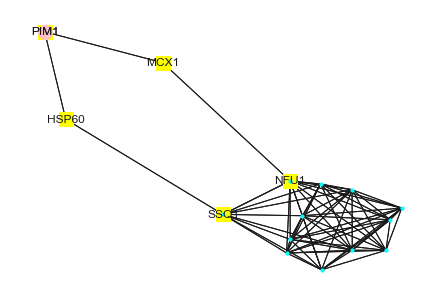

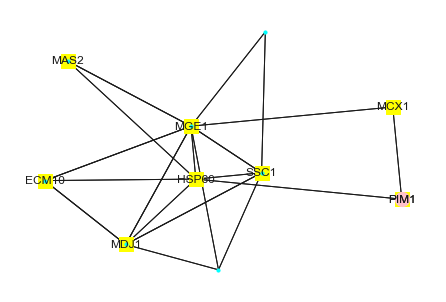

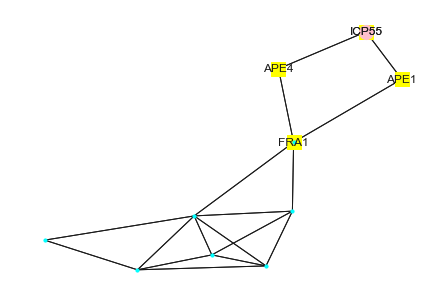

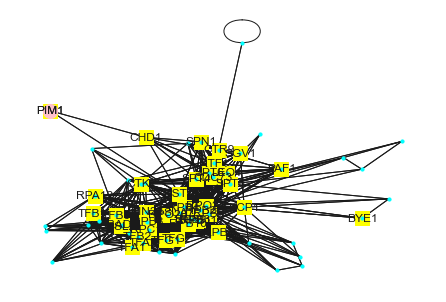

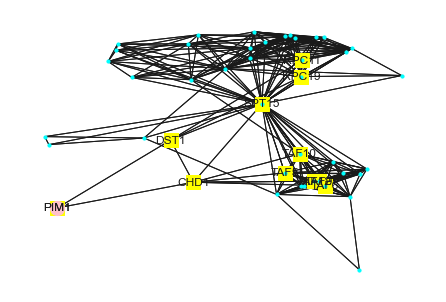

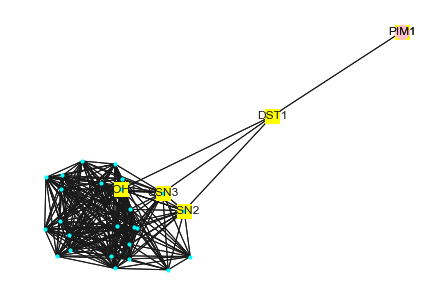

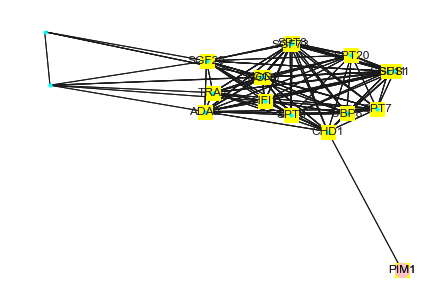

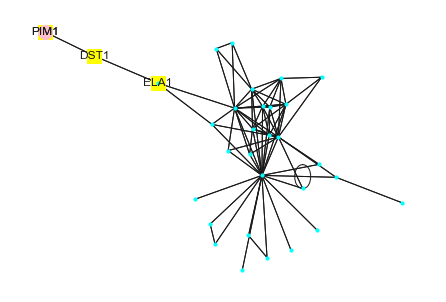

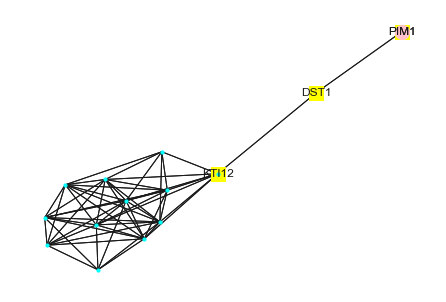

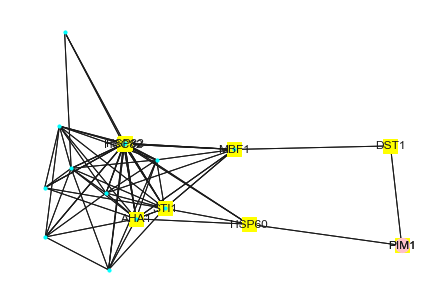

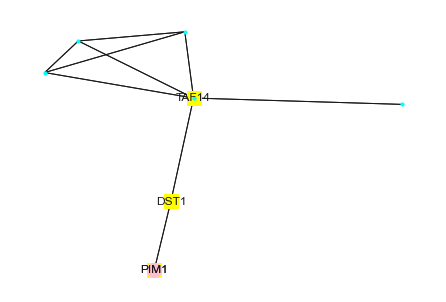

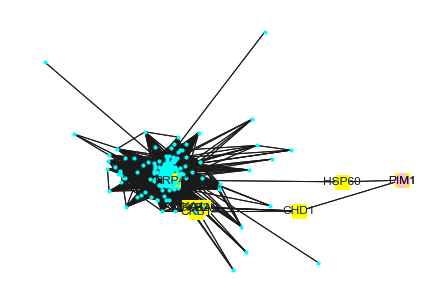

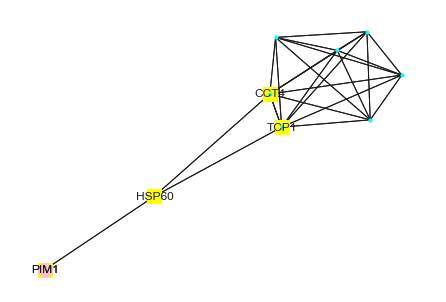

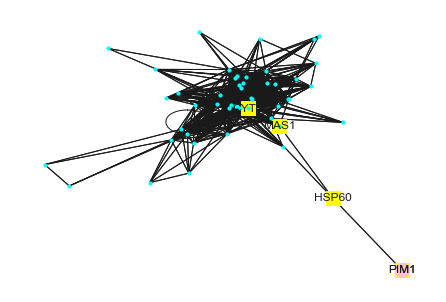

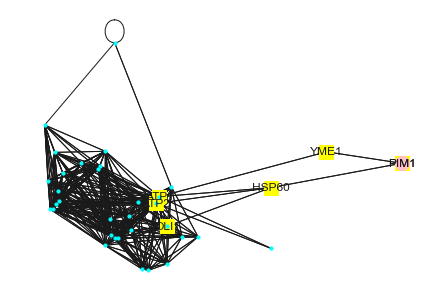

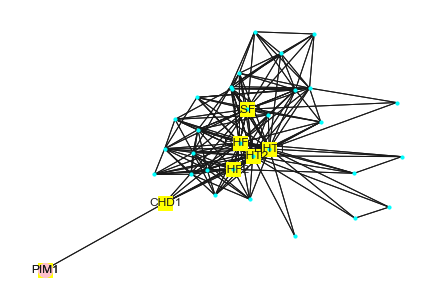

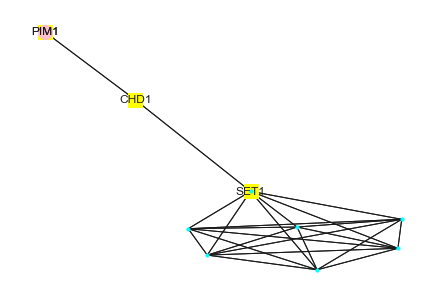

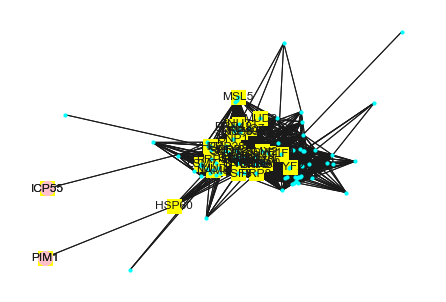

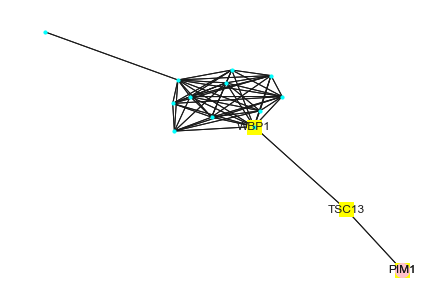

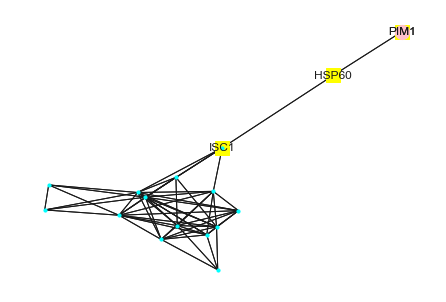

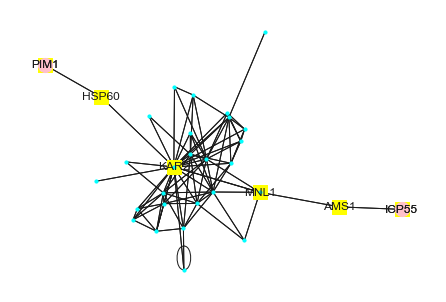

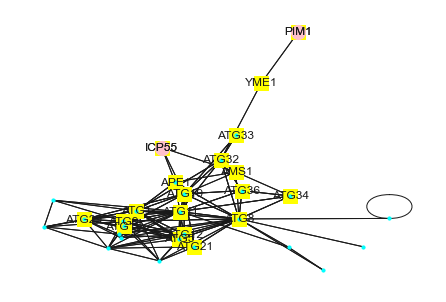

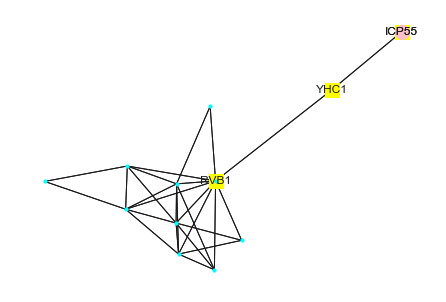

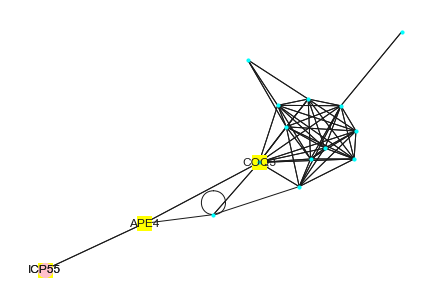

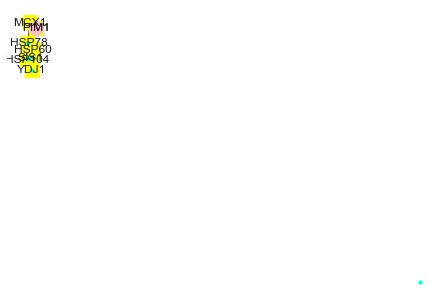

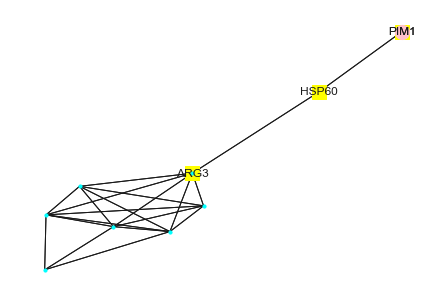

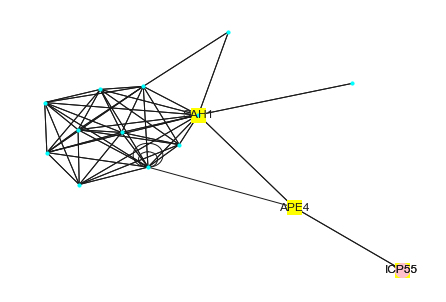

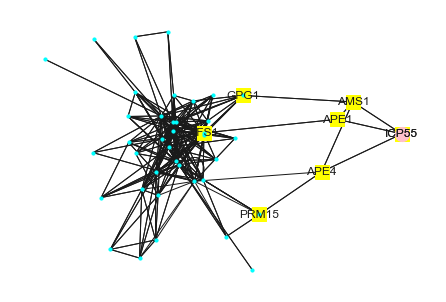

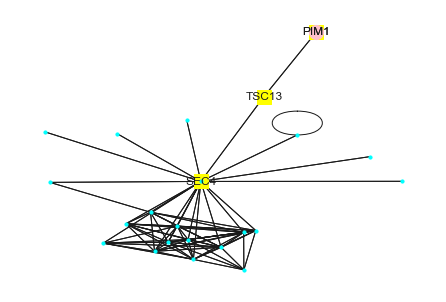

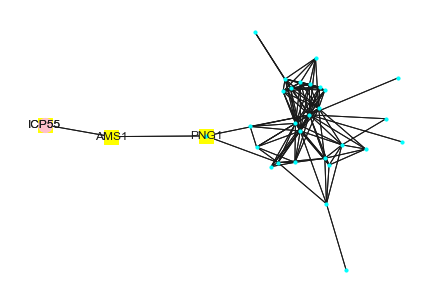

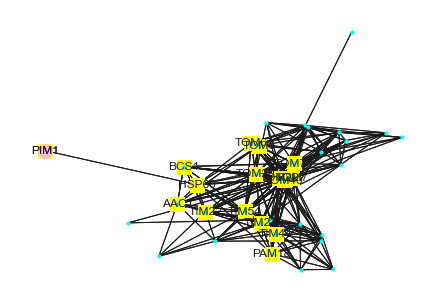

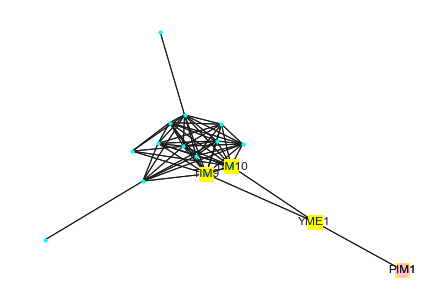

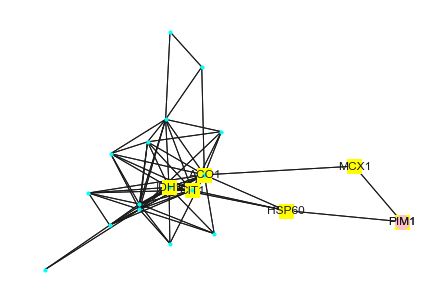

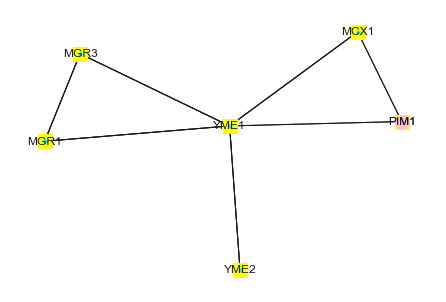

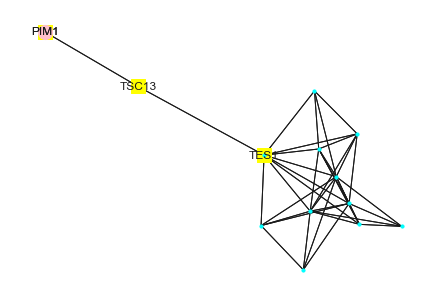

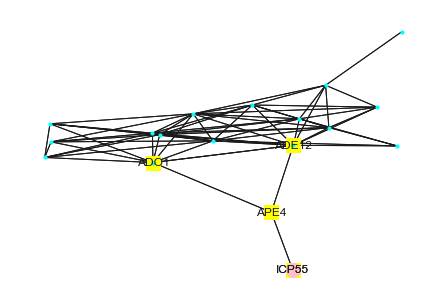

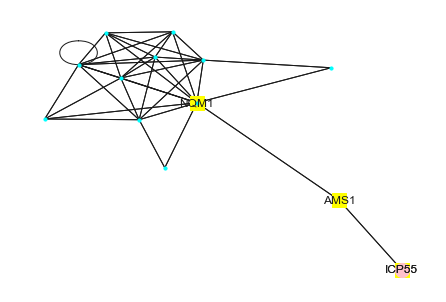

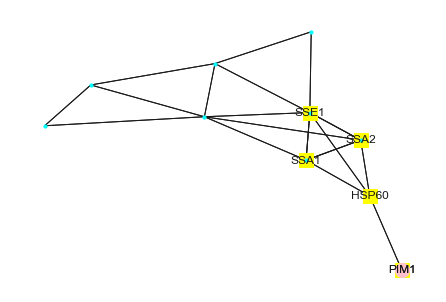

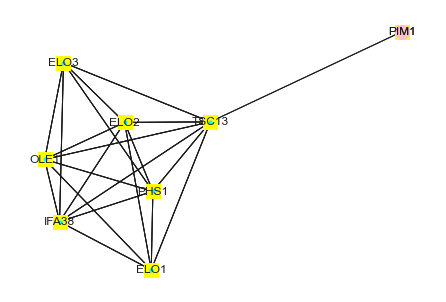

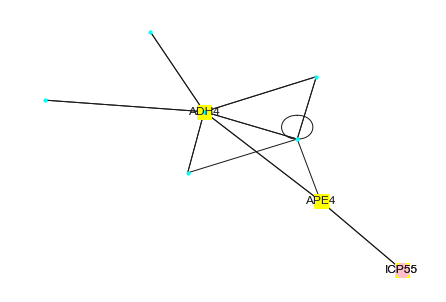

In [83]:
for cluster_id in list(clusters_pl2away_df["cluster_id"]):
    lib.plot.closest_clusters_with_paths_vis('icp55-cc-900-inv', 
                                         'mcl-2.5', 
                                         master_df_name = '..\\data/tables/icp55-cc-900-inv.mcl-2.5.nodes.dataframe.csv',
                                         cluster_id = cluster_id, 
                                         shorp_threshold = 2, ax=None, top_size=200, target_size=200,
                                        save = True) 

## Assessing different channels of evidence
Here I load the STRING network that is expanded to show channels of evidence (e.g. biochemical evidence of interaction, comentioning in abstracts, etc.)

#### Making networks for different channels of evidence
I include adding together ExperimentalBiochemical_Data, Association_in_Curated_Databases, and Co-Mentioned_in_Pubmed_Abstracts

In [86]:
###Load in data
string_channels_raw = pd.read_csv("..\\data/4932.protein.links.detailed.v11.5.txt",
                                 sep = " ",
                                 header = None)

In [118]:
####Process

###Change column names
string_channels_raw = string_channels_raw.set_axis(["node1", 
                                  "node2",
                                 "Neighborhood_in_the_Genome",
                                 "Gene_Fusions",
                                 "Cooccurence_Across_Genomes",
                                 "Co-Expression",
                                 "ExperimentalBiochemical_Data",
                                 "Association_in_Curated_Databases",
                                 "Co-Mentioned_in_Pubmed_Abstracts",
                             "Combined_Score"],
                            axis = 1)

###Add expbioch_coexp_curat
string_channels_raw["expbioch_coexp_curat"] = string_channels_raw["Co-Expression"] + string_channels_raw["ExperimentalBiochemical_Data"] + string_channels_raw["Association_in_Curated_Databases"]

###Export individually
columns = ["Neighborhood_in_the_Genome",
                                 "Gene_Fusions",
                                 "Cooccurence_Across_Genomes",
                                 "Co-Expression",
                                 "ExperimentalBiochemical_Data",
                                 "Association_in_Curated_Databases",
                                 "Co-Mentioned_in_Pubmed_Abstracts",
                                 "Combined_Score",
                                  "expbioch_coexp_curat"]

for column in columns:
    string_specific_channel = string_channels_raw[["node1", "node2", column]]
    string_specific_channel.to_csv("..\\data/4932.protein.links.detailed.v11.5." + column + ".txt",
                                  header = False,
                                  index = False,
                                  sep = " ")

### Combining scores

In [161]:
###Get data
string_channels_raw[(string_channels_raw["node1"] == "4932.YBL022C") &
                    (string_channels_raw["node2"] == "4932.YER017C")]

test_data = list(string_channels_raw[(string_channels_raw["node1"] == "4932.YBL022C") &
                    (string_channels_raw["node2"] == "4932.YER017C")].iloc[0, 2:9])
test_data

[91, 0, 0, 205, 485, 0, 894]

In [164]:
string_channels_raw

,node1,node2,Neighborhood_in_the_Genome,Gene_Fusions,Cooccurence_Across_Genomes,Co-Expression,ExperimentalBiochemical_Data,Association_in_Curated_Databases,Co-Mentioned_in_Pubmed_Abstracts,Combined_Score,expbioch_coexp_curat,recalculated_score,expbioch_coexp_curat_score
0,4932.Q0010,4932.YPL135W,0,0,0,0,0,0,348,347,0,347,41
1,4932.Q0010,4932.Q0017,0,0,0,0,0,0,945,945,0,945,41
2,4932.Q0010,4932.YOL103W,0,0,0,0,0,0,164,163,0,163,41
3,4932.Q0010,4932.YJR122W,0,0,0,0,0,0,528,528,0,528,41
4,4932.Q0010,4932.YGL043W,0,0,0,0,0,0,284,284,0,284,41
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1988587,4932.YPR204W,4932.YPR137C-A,0,0,0,0,0,0,170,169,0,0,0
1988588,4932.YPR204W,4932.YDR316W-A,0,0,0,0,0,0,282,282,0,0,0
1988589,4932.YPR204W,4932.YDR215C,0,0,0,0,0,0,316,315,0,0,0
1988590,4932.YPR204W,4932.YAL017W,0,0,0,0,94,0,103,152,94,0,0


STRING's code

In [165]:
string_channels_raw["expbioch_coexp_curat_score"] = 0

from __future__ import print_function
import os
import sys

##########################################################
## This script combines all the STRING's channels subscores
## into the final combined STRING score.
## It uses unpacked protein.links.full.xx.txt.gz as input
## which can be downloaded from the download subpage:
##      https://string-db.org/cgi/download.pl
##########################################################
 
input_file = "..\\data/4932.protein.links.full.v11.5.txt"

if not os.path.exists(input_file):
    sys.exit("Can't locate input file %s" % input_file)

prior = 0.041

def compute_prior_away(score, prior):

    if score < prior: score = prior
    score_no_prior = (score - prior) / (1 - prior)

    return score_no_prior

header = False
index = 0
for line in open(input_file):
    

    if header:
        header = False
        continue
    
    l = line.split()
    
    ## load the line
        
    (protein1, protein2,
     neighborhood, neighborhood_transferred,
     fusion, cooccurrence,
     homology,
     coexpression, coexpression_transferred,
     experiments, experiments_transferred,
     database, database_transferred,
     textmining, textmining_transferred,
     initial_combined) = l


    ## divide by 1000

    neighborhood = float(neighborhood) / 1000
    neighborhood_transferred = float(neighborhood_transferred) / 1000
    fusion = float(fusion) / 1000
    cooccurrence =  float(cooccurrence) / 1000
    homology = float(homology) / 1000
    coexpression = float(coexpression) / 1000
    coexpression_transferred = float(coexpression_transferred) / 1000
    experiments = float(experiments) / 1000
    experiments_transferred = float(experiments_transferred) / 1000
    database = float(database) / 1000
    database_transferred = float(database_transferred) / 1000
    textmining = float(textmining) / 1000
    textmining_transferred = float(textmining_transferred) / 1000
    initial_combined = int(initial_combined)


    ## compute prior away

    neighborhood_prior_corrected                 = compute_prior_away (neighborhood, prior)             
    neighborhood_transferred_prior_corrected     = compute_prior_away (neighborhood_transferred, prior) 
    fusion_prior_corrected                       = compute_prior_away (fusion, prior)             
    cooccurrence_prior_corrected                 = compute_prior_away (cooccurrence, prior)           
    coexpression_prior_corrected                 = compute_prior_away (coexpression, prior)            
    coexpression_transferred_prior_corrected     = compute_prior_away (coexpression_transferred, prior) 
    experiments_prior_corrected                  = compute_prior_away (experiments, prior)   
    experiments_transferred_prior_corrected      = compute_prior_away (experiments_transferred, prior) 
    database_prior_corrected                     = compute_prior_away (database, prior)      
    database_transferred_prior_corrected         = compute_prior_away (database_transferred, prior)
    textmining_prior_corrected                   = compute_prior_away (textmining, prior)            
    textmining_transferred_prior_corrected       = compute_prior_away (textmining_transferred, prior) 

    ## then, combine the direct and transferred scores for each category:

    neighborhood_both_prior_corrected = 1.0 - (1.0 - neighborhood_prior_corrected) * (1.0 - neighborhood_transferred_prior_corrected)
    coexpression_both_prior_corrected = 1.0 - (1.0 - coexpression_prior_corrected) * (1.0 - coexpression_transferred_prior_corrected)
    experiments_both_prior_corrected = 1.0 - (1.0 - experiments_prior_corrected) * (1.0 - experiments_transferred_prior_corrected)
    database_both_prior_corrected = 1.0 - (1.0 - database_prior_corrected) * (1.0 - database_transferred_prior_corrected)
    textmining_both_prior_corrected = 1.0 - (1.0 - textmining_prior_corrected) * (1.0 - textmining_transferred_prior_corrected)

    ## now, do the homology correction on cooccurrence and textmining:

    cooccurrence_prior_homology_corrected = cooccurrence_prior_corrected * (1.0 - homology)
    textmining_both_prior_homology_corrected = textmining_both_prior_corrected * (1.0 - homology)

    ## next, do the 1 - multiplication:
    #HERE I ONLY COMBINE COEXPRESSION, EXPERIMENTS, AND DATABASE

    combined_score_one_minus = (
        (1.0 - coexpression_both_prior_corrected) *
        (1.0 - experiments_both_prior_corrected) *
        (1.0 - database_both_prior_corrected) ) 

    ## and lastly, do the 1 - conversion again, and put back the prior *exactly once*

    combined_score = (1.0 - combined_score_one_minus)            ## 1- conversion
    combined_score *= (1.0 - prior)                              ## scale down
    combined_score += prior                                      ## and add prior.

    ## round

    combined_score = int(combined_score * 1000)
    
    #Print score
    print(protein1, protein2, combined_score)
    print(initial_combined)
    
    #Add to df
    string_channels_raw.loc[(string_channels_raw["node1"] == protein1) &
                       (string_channels_raw["node2"] == protein2), "expbioch_coexp_curat_score"] = combined_score
    index = index + 1

4932.Q0010 4932.YPL135W 41
347
4932.Q0010 4932.Q0017 41
945
4932.Q0010 4932.YOL103W 41
163
4932.Q0010 4932.YJR122W 41
528
4932.Q0010 4932.YGL043W 41
284
4932.Q0010 4932.YOR207C 41
169
4932.Q0010 4932.YDR020C 41
280
4932.Q0010 4932.Q0143 41
944
4932.Q0010 4932.YBR031W 41
388
4932.Q0010 4932.Q0045 183
183
4932.Q0010 4932.Q0105 238
238
4932.Q0010 4932.Q0092 41
934
4932.Q0010 4932.YDL140C 41
450
4932.Q0010 4932.Q0160 124
342
4932.Q0010 4932.YOR151C 41
570
4932.Q0010 4932.Q0182 41
914
4932.Q0010 4932.Q0297 41
910
4932.Q0010 4932.YBR265W 41
619
4932.Q0010 4932.YDR012W 41
450
4932.Q0010 4932.YDL020C 41
281
4932.Q0010 4932.YKL203C 41
349
4932.Q0010 4932.YGR253C 41
570
4932.Q0010 4932.YDL114W 41
744
4932.Q0010 4932.YDR045C 41
167
4932.Q0010 4932.YLL027W 41
497
4932.Q0010 4932.YER148W 41
163
4932.Q0010 4932.Q0142 41
818
4932.Q0010 4932.YBL091C 41
186
4932.Q0010 4932.Q0032 41
945
4932.Q0010 4932.YPR067W 41
567
4932.Q0010 4932.Q0085 169
169
4932.Q0017 4932.YPL069C 41
167
4932.Q0017 4932.YDL064W 41

4932.Q0045 4932.YMR080C 288
288
4932.Q0045 4932.YML129C 763
959
4932.Q0045 4932.YER015W 41
246
4932.Q0045 4932.YLR439W 41
161
4932.Q0045 4932.YNL178W 84
488
4932.Q0045 4932.YPL029W 42
683
4932.Q0045 4932.YLR038C 999
999
4932.Q0045 4932.YBL038W 75
350
4932.Q0045 4932.YGR222W 315
832
4932.Q0045 4932.YIL114C 41
159
4932.Q0045 4932.YBR151W 41
219
4932.Q0045 4932.YBL022C 43
272
4932.Q0045 4932.YBL080C 41
508
4932.Q0045 4932.YML125C 41
208
4932.Q0045 4932.YPL240C 50
174
4932.Q0045 4932.YHR008C 54
396
4932.Q0045 4932.YNL071W 121
150
4932.Q0045 4932.YMR228W 41
275
4932.Q0045 4932.YKL148C 135
386
4932.Q0045 4932.YPL132W 122
898
4932.Q0045 4932.YDR462W 41
250
4932.Q0045 4932.Q0070 949
951
4932.Q0045 4932.YGR193C 121
150
4932.Q0045 4932.YOL033W 41
213
4932.Q0045 4932.YEL050C 54
264
4932.Q0045 4932.YMR244C-A 41
521
4932.Q0045 4932.YJL052W 41
166
4932.Q0045 4932.YJL003W 315
462
4932.Q0045 4932.YMR110C 43
153
4932.Q0045 4932.YLR348C 173
244
4932.Q0045 4932.YMR090W 197
269
4932.Q0045 4932.YDL067C 970

4932.Q0055 4932.YIL018W 49
219
4932.Q0055 4932.Q0075 147
880
4932.Q0055 4932.Q0045 303
510
4932.Q0055 4932.YDR111C 41
506
4932.Q0055 4932.YOR207C 41
152
4932.Q0055 4932.Q0050 123
216
4932.Q0055 4932.YJR024C 41
281
4932.Q0055 4932.YGR061C 41
297
4932.Q0055 4932.YDR419W 41
213
4932.Q0055 4932.Q0140 41
241
4932.Q0055 4932.YML004C 41
271
4932.Q0055 4932.YOR128C 41
153
4932.Q0055 4932.YGL187C 288
288
4932.Q0055 4932.YJR070C 41
169
4932.Q0055 4932.YEL050C 55
421
4932.Q0055 4932.Q0060 335
361
4932.Q0055 4932.Q0070 405
612
4932.Q0055 4932.YLR320W 315
315
4932.Q0055 4932.YOR205C 41
670
4932.Q0055 4932.YFR031C-A 49
219
4932.Q0055 4932.Q0120 250
830
4932.Q0055 4932.YMR228W 41
531
4932.Q0055 4932.YIR034C 41
571
4932.Q0055 4932.YEL021W 41
244
4932.Q0055 4932.YIR021W 41
345
4932.Q0055 4932.YER095W 41
615
4932.Q0055 4932.YMR288W 41
265
4932.Q0055 4932.YPL097W 41
450
4932.Q0055 4932.YPL054W 41
525
4932.Q0055 4932.Q0255 136
714
4932.Q0055 4932.YOR346W 41
213
4932.Q0055 4932.YEL038W 41
313
4932.Q0055 49

4932.Q0065 4932.YBL013W 41
288
4932.Q0065 4932.YNR001C 41
213
4932.Q0065 4932.YJL130C 41
264
4932.Q0065 4932.YLR395C 699
704
4932.Q0065 4932.YPL078C 46
200
4932.Q0065 4932.YMR176W 113
160
4932.Q0065 4932.YPR117W 41
227
4932.Q0065 4932.YCL017C 52
153
4932.Q0065 4932.YBL045C 613
636
4932.Q0065 4932.YDL004W 52
273
4932.Q0065 4932.YLR333C 41
294
4932.Q0065 4932.Q0080 97
760
4932.Q0065 4932.YIL098C 41
167
4932.Q0065 4932.YDR298C 54
220
4932.Q0065 4932.YOR151C 41
150
4932.Q0065 4932.YOR330C 41
265
4932.Q0065 4932.YPR080W 41
408
4932.Q0065 4932.YHR050W 41
151
4932.Q0065 4932.YFL036W 85
618
4932.Q0065 4932.YBL072C 41
265
4932.Q0065 4932.YER154W 41
274
4932.Q0065 4932.Q0085 826
987
4932.Q0065 4932.YBR024W 60
494
4932.Q0065 4932.YOR358W 41
463
4932.Q0065 4932.Q0110 617
741
4932.Q0065 4932.Q0130 98
854
4932.Q0065 4932.YPR155C 41
295
4932.Q0065 4932.YCR053W 41
154
4932.Q0065 4932.YJR104C 41
265
4932.Q0065 4932.YPL215W 41
159
4932.Q0065 4932.YBR017C 41
157
4932.Q0065 4932.YPL005W 41
481
4932.Q0065 

4932.Q0070 4932.YMR176W 113
160
4932.Q0070 4932.YNR001C 41
213
4932.Q0070 4932.YPR134W 41
526
4932.Q0070 4932.YLR333C 41
294
4932.Q0070 4932.YDL004W 52
273
4932.Q0070 4932.YBL045C 613
636
4932.Q0070 4932.YNL055C 41
159
4932.Q0070 4932.YLR241W 41
214
4932.Q0070 4932.YGR027C 41
294
4932.Q0070 4932.YGR267C 53
161
4932.Q0070 4932.YBL057C 41
154
4932.Q0070 4932.YGL236C 41
652
4932.Q0070 4932.YMR203W 41
167
4932.Q0070 4932.YMR038C 52
162
4932.Q0070 4932.YFR032C-A 52
167
4932.Q0070 4932.YKL141W 207
325
4932.Q0070 4932.YDR019C 41
213
4932.Q0070 4932.YHR051W 845
921
4932.Q0070 4932.YJR113C 75
214
4932.Q0070 4932.YGR061C 41
214
4932.Q0070 4932.Q0050 294
562
4932.Q0070 4932.YLL009C 41
524
4932.Q0070 4932.YOR350C 41
710
4932.Q0070 4932.YBR179C 41
265
4932.Q0070 4932.YLL018C-A 41
336
4932.Q0070 4932.Q0075 231
952
4932.Q0070 4932.YCR005C 41
213
4932.Q0070 4932.YOR266W 41
248
4932.Q0070 4932.YNR045W 41
243
4932.Q0070 4932.YER005W 41
200
4932.Q0070 4932.YPL234C 98
224
4932.Q0070 4932.YER141W 88
483
49

4932.Q0085 4932.YBL022C 45
256
4932.Q0085 4932.YBL080C 53
201
4932.Q0085 4932.YNL290W 41
301
4932.Q0085 4932.YPR160W 41
172
4932.Q0085 4932.YGR220C 120
295
4932.Q0085 4932.YGR222W 41
674
4932.Q0085 4932.YNL071W 49
308
4932.Q0085 4932.YMR228W 41
554
4932.Q0085 4932.YHR008C 41
312
4932.Q0085 4932.YPL240C 41
152
4932.Q0085 4932.YDL201W 41
181
4932.Q0085 4932.YKL148C 88
794
4932.Q0085 4932.YJL092W 41
240
4932.Q0085 4932.YKL080W 900
901
4932.Q0085 4932.YNR043W 41
336
4932.Q0085 4932.YGL114W 189
189
4932.Q0085 4932.YNL185C 120
300
4932.Q0085 4932.YBR092C 41
217
4932.Q0085 4932.YER042W 41
165
4932.Q0085 4932.YPL132W 41
869
4932.Q0085 4932.YFL022C 97
418
4932.Q0085 4932.YBR189W 118
382
4932.Q0085 4932.YHR026W 979
986
4932.Q0085 4932.YNL192W 41
152
4932.Q0085 4932.YGR174C 41
526
4932.Q0085 4932.YHR190W 41
188
4932.Q0085 4932.YMR064W 41
246
4932.Q0085 4932.YGR192C 41
230
4932.Q0085 4932.YDL078C 46
183
4932.Q0085 4932.YER148W 41
168
4932.Q0085 4932.YMR271C 41
167
4932.Q0085 4932.YGL103W 122
216
4

4932.Q0085 4932.YLR382C 41
168
4932.Q0085 4932.YIL111W 41
266
4932.Q0085 4932.YJR103W 41
161
4932.Q0085 4932.YDR350C 288
861
4932.Q0085 4932.YOR241W 52
255
4932.Q0085 4932.YOR074C 55
151
4932.Q0085 4932.Q0045 975
999
4932.Q0085 4932.YNL284C 122
216
4932.Q0085 4932.YHR091C 41
390
4932.Q0085 4932.YML120C 41
371
4932.Q0085 4932.YIL136W 288
381
4932.Q0085 4932.YOR125C 43
167
4932.Q0085 4932.YLL026W 41
271
4932.Q0085 4932.YPL110C 41
150
4932.Q0085 4932.YBR044C 41
167
4932.Q0085 4932.YOL114C 70
299
4932.Q0085 4932.YHR074W 41
156
4932.Q0085 4932.YLR239C 41
298
4932.Q0085 4932.YMR260C 41
396
4932.Q0085 4932.Q0080 970
999
4932.Q0085 4932.YOR020W-A 540
540
4932.Q0085 4932.YOL021C 41
179
4932.Q0085 4932.YKR087C 41
626
4932.Q0085 4932.YKR070W 49
308
4932.Q0085 4932.YDL004W 999
999
4932.Q0085 4932.YNL328C 41
205
4932.Q0085 4932.YIL057C 41
240
4932.Q0085 4932.YBL045C 53
480
4932.Q0085 4932.YPR102C 211
575
4932.Q0085 4932.YPL252C 41
297
4932.Q0085 4932.YDR064W 96
635
4932.Q0085 4932.YJR047C 58
370
49

4932.Q0092 4932.YJR144W 41
214
4932.Q0092 4932.YFL036W 41
846
4932.Q0092 4932.YMR284W 41
240
4932.Q0092 4932.YAL015C 41
760
4932.Q0092 4932.YJL208C 41
480
4932.Q0092 4932.YDR332W 41
747
4932.Q0092 4932.Q0032 41
897
4932.Q0092 4932.Q0140 41
705
4932.Q0092 4932.Q0085 41
280
4932.Q0092 4932.YGL187C 41
349
4932.Q0092 4932.YMR164C 41
271
4932.Q0092 4932.Q0142 41
745
4932.Q0092 4932.YOR258W 41
213
4932.Q0092 4932.Q0130 41
163
4932.Q0092 4932.YMR106C 41
207
4932.Q0092 4932.YBR163W 41
654
4932.Q0092 4932.YML061C 41
386
4932.Q0092 4932.YDR296W 41
917
4932.Q0092 4932.Q0182 41
892
4932.Q0092 4932.YKL114C 41
179
4932.Q0092 4932.YEL021W 41
186
4932.Q0092 4932.YMR228W 41
450
4932.Q0092 4932.Q0105 41
163
4932.Q0092 4932.Q0017 41
848
4932.Q0092 4932.YFL016C 41
248
4932.Q0092 4932.YER095W 41
165
4932.Q0092 4932.Q0065 41
453
4932.Q0092 4932.Q0010 41
934
4932.Q0092 4932.YML060W 41
659
4932.Q0092 4932.YOL095C 41
288
4932.Q0092 4932.YDL101C 41
169
4932.Q0092 4932.YPL029W 41
339
4932.Q0092 4932.YDR012W 41
2

4932.Q0105 4932.YER154W 315
851
4932.Q0105 4932.Q0085 962
999
4932.Q0105 4932.YCR060W 41
265
4932.Q0105 4932.Q0110 800
823
4932.Q0105 4932.Q0130 249
965
4932.Q0105 4932.YOR096W 41
169
4932.Q0105 4932.YLR289W 41
218
4932.Q0105 4932.YDL044C 288
825
4932.Q0105 4932.YGL030W 41
244
4932.Q0105 4932.YJR123W 74
199
4932.Q0105 4932.YPL215W 772
978
4932.Q0105 4932.YPL005W 41
388
4932.Q0105 4932.YGR082W 41
347
4932.Q0105 4932.YLL041C 905
982
4932.Q0105 4932.YGR084C 41
215
4932.Q0105 4932.YPR191W 996
999
4932.Q0105 4932.YPR062W 41
169
4932.Q0105 4932.YGR062C 900
941
4932.Q0105 4932.YDL119C 41
279
4932.Q0105 4932.YPL271W 49
173
4932.Q0105 4932.YDR194C 41
650
4932.Q0105 4932.Q0010 238
238
4932.Q0105 4932.YDR405W 41
530
4932.Q0105 4932.YIL021W 49
215
4932.Q0105 4932.YFL037W 41
323
4932.Q0105 4932.YDR065W 41
284
4932.Q0105 4932.YBR003W 41
525
4932.Q0105 4932.YLR203C 463
841
4932.Q0105 4932.YER077C 41
399
4932.Q0105 4932.YER153C 41
183
4932.Q0105 4932.YGR255C 41
427
4932.Q0105 4932.YPL189C-A 41
286
493

4932.Q0110 4932.YAL033W 41
245
4932.Q0110 4932.YLR142W 41
204
4932.Q0110 4932.YPL234C 91
444
4932.Q0110 4932.YEL027W 91
444
4932.Q0110 4932.YHR033W 41
216
4932.Q0110 4932.YDL069C 41
780
4932.Q0110 4932.YJL166W 752
845
4932.Q0110 4932.YOR128C 55
181
4932.Q0110 4932.YEL052W 41
154
4932.Q0110 4932.Q0140 185
415
4932.Q0110 4932.YFR033C 822
863
4932.Q0110 4932.YER141W 41
264
4932.Q0110 4932.YGR058W 41
201
4932.Q0110 4932.YKR079C 41
220
4932.Q0110 4932.YGR062C 41
206
4932.Q0110 4932.YPR191W 525
642
4932.Q0110 4932.YGR082W 41
163
4932.Q0110 4932.YLL041C 91
489
4932.Q0110 4932.YPL215W 41
520
4932.Q0110 4932.YPL005W 41
614
4932.Q0110 4932.YMR272C 41
487
4932.Q0110 4932.YMR203W 41
214
4932.Q0110 4932.YJR123W 74
199
4932.Q0110 4932.YLR289W 41
190
4932.Q0110 4932.YGL030W 41
244
4932.Q0110 4932.YER077C 41
165
4932.Q0110 4932.YLR203C 41
216
4932.Q0110 4932.YKL141W 84
489
4932.Q0110 4932.YJR113C 74
199
4932.Q0110 4932.YIL021W 49
215
4932.Q0110 4932.YDR405W 41
264
4932.Q0110 4932.YDR197W 41
780
4932.Q

4932.Q0120 4932.YLR359W 41
205
4932.Q0120 4932.YDL120W 41
264
4932.Q0120 4932.YML009C 53
285
4932.Q0120 4932.YDL085W 900
908
4932.Q0120 4932.Q0255 246
246
4932.Q0120 4932.YKL113C 41
157
4932.Q0120 4932.YIR021W 41
698
4932.Q0120 4932.YPL013C 54
388
4932.Q0120 4932.YIR034C 41
388
4932.Q0120 4932.YGR231C 41
156
4932.Q0120 4932.YDR320C 41
265
4932.Q0120 4932.YMR089C 41
167
4932.Q0120 4932.YPL097W 41
450
4932.Q0120 4932.YNL052W 918
928
4932.Q0120 4932.YHR024C 683
698
4932.Q0120 4932.YOL023W 41
265
4932.Q0120 4932.YPR110C 49
215
4932.Q0120 4932.YOR116C 44
159
4932.Q0120 4932.YGR183C 940
974
4932.Q0120 4932.YJR119C 85
192
4932.Q0120 4932.YGL191W 918
926
4932.Q0120 4932.YLR388W 179
250
4932.Q0120 4932.YDR376W 41
226
4932.Q0120 4932.YAL033W 41
245
4932.Q0120 4932.YLR142W 41
204
4932.Q0120 4932.YPL234C 91
444
4932.Q0120 4932.YEL027W 91
444
4932.Q0120 4932.YDL069C 41
712
4932.Q0120 4932.YOR128C 55
236
4932.Q0120 4932.YJL166W 948
967
4932.Q0120 4932.YEL052W 41
154
4932.Q0120 4932.YFR033C 962
973
4

4932.Q0130 4932.YDL085W 49
188
4932.Q0130 4932.YML009C 92
524
4932.Q0130 4932.YMR286W 185
186
4932.Q0130 4932.YJR094W-A 203
203
4932.Q0130 4932.YOL023W 55
611
4932.Q0130 4932.Q0092 41
163
4932.Q0130 4932.YPL131W 209
277
4932.Q0130 4932.YGL191W 345
937
4932.Q0130 4932.YGL135W 123
214
4932.Q0130 4932.YDL033C 41
614
4932.Q0130 4932.YOR116C 105
157
4932.Q0130 4932.YML026C 149
194
4932.Q0130 4932.YKL100C 48
162
4932.Q0130 4932.YCR012W 120
320
4932.Q0130 4932.YER117W 177
200
4932.Q0130 4932.YGL136C 41
500
4932.Q0130 4932.YHR025W 49
300
4932.Q0130 4932.YPL198W 273
273
4932.Q0130 4932.YPR031W 41
157
4932.Q0130 4932.YMR023C 41
154
4932.Q0130 4932.YLR048W 175
192
4932.Q0130 4932.YGR029W 49
182
4932.Q0130 4932.YGR150C 41
497
4932.Q0130 4932.YGR034W 146
163
4932.Q0130 4932.YLL001W 41
166
4932.Q0130 4932.YBR181C 219
219
4932.Q0130 4932.YJR090C 600
600
4932.Q0130 4932.YGR007W 49
336
4932.Q0130 4932.YJR048W 402
488
4932.Q0130 4932.YKR016W 114
191
4932.Q0130 4932.YBR019C 41
159
4932.Q0130 4932.YBL033C

4932.Q0130 4932.YJL063C 123
219
4932.Q0130 4932.YDR234W 92
496
4932.Q0130 4932.YPL271W 997
999
4932.Q0130 4932.YIL021W 115
327
4932.Q0130 4932.YDR405W 116
719
4932.Q0130 4932.YDR476C 41
345
4932.Q0130 4932.YPR191W 572
918
4932.Q0130 4932.YGR062C 292
827
4932.Q0130 4932.YHR032W 41
281
4932.Q0130 4932.YER078C 41
172
4932.Q0130 4932.YHR203C 205
205
4932.Q0130 4932.YLR289W 52
194
4932.Q0130 4932.YDL044C 41
345
4932.Q0130 4932.YPL005W 41
388
4932.Q0130 4932.YPL215W 43
848
4932.Q0130 4932.YLL041C 185
734
4932.Q0130 4932.YKL056C 173
263
4932.Q0130 4932.YOR293W 175
175
4932.Q0130 4932.YDR025W 204
239
4932.Q0130 4932.YNL267W 41
154
4932.Q0130 4932.YBR024W 75
364
4932.Q0130 4932.YHL004W 116
169
4932.Q0130 4932.YLR164W 100
262
4932.Q0130 4932.YBR084C-A 88
253
4932.Q0130 4932.Q0085 996
999
4932.Q0130 4932.YDL218W 41
243
4932.Q0130 4932.YBL072C 252
252
4932.Q0130 4932.YOR234C 161
195
4932.Q0130 4932.YDL083C 185
191
4932.Q0130 4932.YNL315C 41
677
4932.Q0130 4932.YLR378C 125
237
4932.Q0130 4932.YMR21

4932.Q0130 4932.YJL190C 177
256
4932.Q0130 4932.YJR127C 41
161
4932.Q0130 4932.YNL177C 210
265
4932.Q0130 4932.YKL195W 98
196
4932.Q0130 4932.YPL078C 999
999
4932.Q0130 4932.YFR031C-A 202
275
4932.Q0130 4932.YDL140C 105
185
4932.Q0130 4932.YPL145C 41
327
4932.Q0130 4932.YNR001C 905
909
4932.Q0130 4932.YJR077C 499
499
4932.Q0130 4932.YLR367W 177
256
4932.Q0130 4932.YOR020C 515
522
4932.Q0130 4932.YLR410W-B 41
388
4932.Q0130 4932.YOR367W 41
156
4932.Q0130 4932.YBL068W-A 43
185
4932.Q0130 4932.YMR257C 41
526
4932.Q0130 4932.YBL027W 88
253
4932.Q0130 4932.YMR162C 62
335
4932.Q0130 4932.YOL039W 179
179
4932.Q0130 4932.YJL189W 75
198
4932.Q0130 4932.YOR125C 61
239
4932.Q0130 4932.YNL301C 202
266
4932.Q0130 4932.YOL114C 121
383
4932.Q0130 4932.YGR100W 41
265
4932.Q0140 4932.YLR067C 41
748
4932.Q0140 4932.YBR122C 800
869
4932.Q0140 4932.Q0105 99
904
4932.Q0140 4932.YGR062C 41
215
4932.Q0140 4932.YDR347W 979
980
4932.Q0140 4932.YDR476C 41
566
4932.Q0140 4932.YJL131C 315
796
4932.Q0140 4932.YGR0

4932.Q0160 4932.YER087C-B 41
694
4932.Q0160 4932.YFL065C 41
242
4932.Q0160 4932.YDL014W 41
210
4932.Q0160 4932.YDR296W 41
451
4932.Q0160 4932.YOL064C 41
451
4932.Q0160 4932.YBR223C 41
529
4932.Q0160 4932.YBR009C 41
390
4932.Q0160 4932.YDR499W 41
325
4932.Q0160 4932.YPR062W 41
213
4932.Q0160 4932.YGL172W 41
281
4932.Q0160 4932.YFL039C 41
555
4932.Q0160 4932.YDR030C 41
163
4932.Q0160 4932.Q0085 132
177
4932.Q0160 4932.YLR265C 41
313
4932.Q0160 4932.YDR004W 41
370
4932.Q0160 4932.YMR190C 41
760
4932.Q0160 4932.YJR009C 41
612
4932.Q0160 4932.YMR201C 41
282
4932.Q0160 4932.YDR386W 41
713
4932.Q0160 4932.YDL042C 41
370
4932.Q0160 4932.YEL063C 41
710
4932.Q0160 4932.YCR014C 41
571
4932.Q0160 4932.YDR225W 41
631
4932.Q0160 4932.YLR378C 41
913
4932.Q0160 4932.YGR212W 41
270
4932.Q0160 4932.YNL088W 41
213
4932.Q0160 4932.YML124C 41
524
4932.Q0160 4932.YMR284W 41
868
4932.Q0160 4932.YBR098W 41
282
4932.Q0160 4932.YAR007C 41
612
4932.Q0160 4932.YER099C 41
315
4932.Q0160 4932.YPR080W 41
481
4932.Q0

4932.Q0250 4932.YDR256C 41
291
4932.Q0250 4932.YIL134W 51
219
4932.Q0250 4932.YML096W 41
161
4932.Q0250 4932.YOL126C 121
232
4932.Q0250 4932.YER053C 222
669
4932.Q0250 4932.Q0275 999
999
4932.Q0250 4932.YOR124C 41
252
4932.Q0250 4932.YER028C 360
360
4932.Q0250 4932.YML106W 41
193
4932.Q0250 4932.YDR119W-A 958
958
4932.Q0250 4932.YAL038W 41
234
4932.Q0250 4932.YMR293C 52
281
4932.Q0250 4932.YDR216W 360
360
4932.Q0250 4932.YPR048W 398
447
4932.Q0250 4932.YGR044C 360
360
4932.Q0250 4932.YKL150W 53
177
4932.Q0250 4932.Q0120 992
999
4932.Q0250 4932.YPL013C 53
193
4932.Q0250 4932.YGR231C 183
423
4932.Q0250 4932.YIR021W 41
165
4932.Q0250 4932.YJR106W 41
161
4932.Q0250 4932.YLR131C 360
360
4932.Q0250 4932.YOL122C 108
282
4932.Q0250 4932.YCR024C 42
348
4932.Q0250 4932.YOR017W 41
244
4932.Q0250 4932.YGL129C 41
549
4932.Q0250 4932.YGR202C 41
169
4932.Q0250 4932.YGR235C 41
163
4932.Q0250 4932.YKL173W 105
222
4932.Q0250 4932.YNL163C 71
193
4932.Q0250 4932.YPL175W 52
311
4932.Q0250 4932.YDR079W 41
5

4932.Q0250 4932.YBR120C 41
591
4932.Q0250 4932.YDL107W 315
781
4932.Q0250 4932.YER023W 41
175
4932.Q0250 4932.YOL086C 50
154
4932.Q0250 4932.YER182W 41
317
4932.Q0250 4932.YDR175C 41
192
4932.Q0250 4932.YLR304C 49
534
4932.Q0250 4932.YJL208C 75
259
4932.Q0250 4932.YAL058W 147
165
4932.Q0250 4932.YLR290C 247
476
4932.Q0250 4932.YEL024W 998
999
4932.Q0250 4932.YHR007C 41
494
4932.Q0250 4932.YOR196C 52
326
4932.Q0250 4932.YPR166C 208
424
4932.Q0250 4932.YNL306W 55
175
4932.Q0250 4932.YJL164C 85
150
4932.Q0250 4932.YER102W 41
363
4932.Q0250 4932.YJL041W 41
163
4932.Q0250 4932.YOR247W 41
165
4932.Q0250 4932.YBR256C 41
474
4932.Q0250 4932.YDR322C-A 41
179
4932.Q0250 4932.YLR375W 360
360
4932.Q0250 4932.YNR017W 489
549
4932.Q0250 4932.YBR263W 115
156
4932.Q0250 4932.YGL107C 41
487
4932.Q0250 4932.YNL100W 41
248
4932.Q0250 4932.YBR196C 41
486
4932.Q0250 4932.YFR015C 50
201
4932.Q0250 4932.YIL022W 41
224
4932.Q0250 4932.YEL009C 509
562
4932.Q0250 4932.YDR043C 360
360
4932.Q0250 4932.YCR005C 58


4932.Q0255 4932.YDR140W 41
453
4932.Q0255 4932.YOR355W 41
710
4932.Q0255 4932.YPL048W 41
281
4932.Q0255 4932.Q0055 136
714
4932.Q0275 4932.YOR330C 41
814
4932.Q0275 4932.YOL159C 41
200
4932.Q0275 4932.YDR379C-A 41
156
4932.Q0275 4932.YDR298C 47
540
4932.Q0275 4932.YHR202W 41
153
4932.Q0275 4932.YBL072C 41
372
4932.Q0275 4932.YKR059W 288
382
4932.Q0275 4932.YFL036W 41
560
4932.Q0275 4932.YHR050W 41
193
4932.Q0275 4932.YER152C 41
570
4932.Q0275 4932.YBR024W 75
425
4932.Q0275 4932.YMR145C 900
909
4932.Q0275 4932.Q0085 945
998
4932.Q0275 4932.YER154W 479
720
4932.Q0275 4932.YDR349C 41
186
4932.Q0275 4932.YGL147C 41
171
4932.Q0275 4932.YCR053W 41
191
4932.Q0275 4932.Q0130 133
877
4932.Q0275 4932.Q0110 922
976
4932.Q0275 4932.YLL041C 185
700
4932.Q0275 4932.YBR209W 41
209
4932.Q0275 4932.YPR191W 991
996
4932.Q0275 4932.YDL119C 41
526
4932.Q0275 4932.YGR062C 315
405
4932.Q0275 4932.YDR037W 41
181
4932.Q0275 4932.YDR194C 41
280
4932.Q0275 4932.YDR234W 41
296
4932.Q0275 4932.YPL271W 95
214
4932

4932.YAL001C 4932.YGR109W-B 41
670
4932.YAL001C 4932.YKL002W 41
190
4932.YAL001C 4932.YPR187W 600
628
4932.YAL001C 4932.YDR022C 41
250
4932.YAL001C 4932.YBR154C 600
627
4932.YAL001C 4932.YBR245C 315
315
4932.YAL001C 4932.YOR289W 41
282
4932.YAL001C 4932.YNR003C 620
644
4932.YAL001C 4932.YKL144C 600
627
4932.YAL001C 4932.YMR080C 41
275
4932.YAL001C 4932.YBR240C 41
345
4932.YAL001C 4932.YOR116C 600
818
4932.YAL001C 4932.YLR420W 237
237
4932.YAL001C 4932.YML089C 41
349
4932.YAL001C 4932.YNL038W 41
574
4932.YAL001C 4932.YOR210W 600
637
4932.YAL001C 4932.YLL013C 463
463
4932.YAL001C 4932.YKL032C 41
243
4932.YAL001C 4932.YBR237W 154
154
4932.YAL001C 4932.YJL130C 341
362
4932.YAL001C 4932.YEL021W 41
217
4932.YAL001C 4932.YKL195W 257
257
4932.YAL001C 4932.YPL014W 41
483
4932.YAL001C 4932.YJR127C 41
451
4932.YAL001C 4932.YGR246C 957
987
4932.YAL001C 4932.YPR110C 600
617
4932.YAL001C 4932.YMR093W 278
278
4932.YAL001C 4932.YMR283C 311
311
4932.YAL001C 4932.YLR442C 254
254
4932.YAL001C 4932.YDR449

KeyboardInterrupt: 